# Querying a track with SQL-like commands


Avec la librairie tracklib il est possible de: 
1. construire une nouvelle trace en sélectionnant certaines observations d'une trace donnée
2. ou de calculer des informations à partir d'une trace. 

Pour cela il faut écrire une expression en utilisant les règles d'écriture du SQL et appeler la méthode ``query``. Par exemple la requête ci-dessous construit une nouvelle trace avec uniquement les observations dont la vitesse est inférieure à 0.5 m/s.

<div class="alert alert-block alert-success" style="padding-left:4em">
queryTxt  = ' SELECT * '
    
queryTxt += ' WHERE speed < 0.5 '
    
track2 = track.query(queryTxt)
</div>
        
Attention, la syntaxe est inspirée de SQL mais est un peu plus restrictive.

## Import de la librairie tracklib

The first task is only useful for the online notebook

In [1]:
import os
import sys

# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Import de la librairie tracklib
import tracklib as trk

# Et d'autres
import matplotlib.pyplot as plt

code running in a no qgis environment
code running in a no qgis environment


## Chargement d'une trace pour les exemples

On ajoute les AF suivantes: speed, heading and direction

In [3]:
# Load a track
trk.ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")
tracks = trk.TrackReader.readFromGpx('../../../data/gpx/activity_5807084803.gpx')
trace = tracks.getTrack(0)
trace.toENUCoords()
print ('')

trace.addAnalyticalFeature(trk.speed)
trace.addAnalyticalFeature(trk.heading)
trace.addAnalyticalFeature(trk.orientation)

print (trace.getListAnalyticalFeatures())


['speed', 'heading', 'orientation']


## General rules

- Only SELECT and WHERE clauses are available
- SELECT is mandatory and WHERE is optional
- Blank space must be used between every other words, symbols and operators
- Capital letters must be used for SQL keywords SELECT, WHERE, AND, OR and aggregators 

**Fields**

- All analytical features + x, y, z, t, and timestamp are available as fields
- Fields are written without quotes. They must not contain blank spaces
- "t" is time as integer in seconds since 1970/01/01 00:00:00, and "timestamp" is GPSTIme object

**Aggregators**

- All unary operators as described in Operator.py, except MSE, are available. 


## Output depends on the ``SELECT`` clause

### new ``Track``

In [4]:
trace1 = trace.query("SELECT *")
trace1.summary()

-------------------------------------
GPS track #0 of user 0:
-------------------------------------
  Nb of pt(s):   190
  Ref sys id   : ENU
  Starting at  : 11/11/2020 15:39:54
  Ending at    : 11/11/2020 15:52:00
  Duration     : 726.000 s
  Length       : 2412.144 m
-------------------------------------
Analytical feature(s):
 - speed
 - heading
 - orientation
-------------------------------------



### n-dimensional array of observations

If "SELECT f1, f2... fp", then output is a (p x n)-dimensional array, with p = number of fields 
queried and n = number of observations selected by the WHERE conditions.

Text(0.5, 1.0, 'heading for speed >= 5')

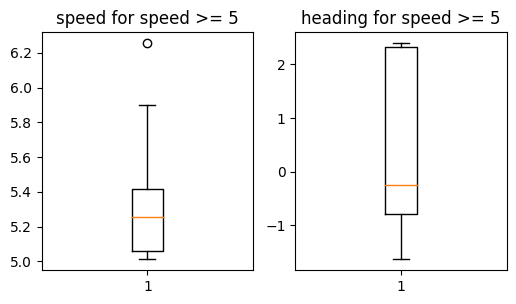

In [5]:
tab = trace.query("SELECT speed, heading WHERE speed >= 5")

plt.figure(figsize=(6, 2))
plt.subplots_adjust(top=1.3, wspace=0.2, hspace=0.2)

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax1.boxplot(tab[0])
ax1.set_title('speed for speed >= 5')

ax2 = plt.subplot2grid((1, 2), (0, 1))
ax2.boxplot(tab[1])
ax2.set_title('heading for speed >= 5')

### 1-p dimensional array

If "SELECT AGG1(f1), AGG2(f2)... AGGp(fp)", with AGG1, AGG2,.. AGGp, a set of p aggregators, 
then output is a p-dimensional array, with on value for each aggregator

Note that operators take as input only analytical feature names. Therefore, "SELECT COUNT(*)" syntax 
is not allowed and must be replaced equivalently by "SELECT COUNT(f)" with any AF name f.

In [6]:
queryTxt  = " SELECT COUNT(speed), AVG(speed) "
queryTxt += " WHERE orientation = 1 "
    
values = trace.query(queryTxt)
print (values)

[14, 3.1897129536707767]


### Float value

If "SELECT AGG(f)", then output is the floating point value returned by the operator.

In [7]:
value = trace.query("SELECT AVG(speed)")
print (value)

3.696302107811199


## Where clause

WHERE clause may contain as many conditions as needed, separated by OR/AND key words

Parenthesis are not allowed within WHERE clause. Use boolean algebra rules to reformulate query without parenthesis: e.g. A AND (B OR C) = A AND B OR A AND C. Or use successive queries.

Each condition must contain exactly 3 parts (separated by blank spaces) in this exact order:
	(1) the name of an analytical feature to test
	(2) a comparison operator among >, <, >=, <=, ==, != and LIKE (with % in str and timestamps)
	(3) a threshold value which is automatically casted to the type of the AF given in (1). Intended types accepted are: integers, floats, strings, boolean and GPSTime. When ObsTime is used as a threshold value, eventhough it may contain 2 parts (date and time), it must not be enclosed within quotes. For boolean, "1", "T" and "TRUE" are considered as logical True, all other values are considered as False. 

Important: no computation allowed in WHERE conditions. E.g. "... WHERE z-2 > 10" not allowed

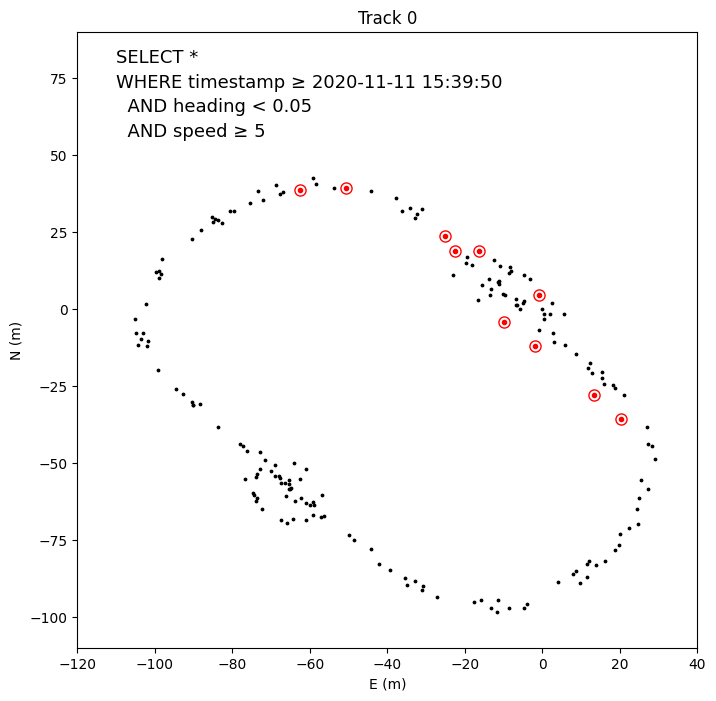

In [8]:
query  = " SELECT * "
query += " WHERE timestamp >= 2020-11-11 15:39:50 "  
query += "   AND heading < 0.05 "
query += "   AND speed >= 5 "
traceRapide = trace.query(query)

plt.figure(figsize=(8, 8))
trace.plot('ko', pointsize=3, append=True)
traceRapide.plotAsMarkers(type=trk.MARKERS_TYPE_SPOT, append=True)

plt.xlim([-120, 40])
plt.ylim([-110, 90])
plt.text(-110, 80, 'SELECT *', size=13)
plt.text(-110, 72, 'WHERE timestamp ≥ 2020-11-11 15:39:50', size=13)
plt.text(-110, 64, '  AND heading < 0.05 ', size=13)
plt.text(-110, 56, '  AND speed ≥ 5', size=13)
plt.show()